In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

h_image_size = 32
h_max_allowable_filters = 256
h_batch_size = 512
train_dir = 'Train/'

In [2]:
def load_resize_batch(index, batch_size, directory):

    file_paths = [directory + file_name for file_name in os.listdir(directory)]
    file_batch = file_paths[index * batch_size:(index+1) * batch_size]

    image_batch = np.empty((0, h_image_size, h_image_size,3))
    for filepath in file_batch:
        image = np.expand_dims(
            cv2.resize(cv2.imread(filepath),(h_image_size, h_image_size)),0)
        image_batch = np.concatenate((image_batch, image))

    return image_batch

In [3]:
def preprocess_batch(image_batch):

    batch_l_channels = np.empty((0,h_image_size, h_image_size,1))
    batch_ab_channels = np.empty((0,h_image_size ,h_image_size,2))
    
    for image in image_batch:
        image = cv2.cvtColor(image.astype(np.uint8),cv2.COLOR_BGR2LAB)
        image = np.add(image,-128)/128

        l_channel = np.expand_dims(np.expand_dims(image[:,:,0],2),0)   
        ab_channels = np.expand_dims(image[:,:,1:],0)
        batch_l_channels = np.concatenate((batch_l_channels, l_channel))
        batch_ab_channels = np.concatenate((batch_ab_channels, ab_channels))

    #batch_l_channels = np.array(batch_l_channels)
    batch_l_channels = torch.tensor(batch_l_channels, dtype=torch.float32)
    batch_l_channels = batch_l_channels.movedim(-1,1)

    #batch_ab_channels = np.array(batch_ab_channels)
    batch_ab_channels = torch.tensor(batch_ab_channels, dtype=torch.float32)
    batch_ab_channels = batch_ab_channels.movedim(-1,1)

    return batch_l_channels.to('cuda') , batch_ab_channels.to('cuda')

In [4]:
class Downsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 5, stride = 1 ,padding='same').to('cuda')
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')
        self.pool = nn.AvgPool2d(2).to('cuda')

    def forward(self, x):
        #print(f'downbl {x.shape}')
        block = self.conv(x)
        block = self.pool(block)
        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        
        return block.to('cuda')

In [5]:
class Upsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_filters, out_filters,kernel_size = 2, stride = 2).to('cuda')
        self.norm = nn.BatchNorm2d(out_filters).to('cuda')
        self.dropout = nn.Dropout(0.2).to('cuda')
        self.activation = nn.LeakyReLU(0.1).to('cuda')

    def forward(self, x, skip):

        block = self.conv(x)

        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        
        #print(f'upbl {block.shape}')
        #print(f'skip {skip.shape}')
        
        block = torch.cat((block, skip),1)
        
        #print(f'catted {block.shape}')
        
        return block.to('cuda')

In [6]:
class Generator(nn.Module):

    def __init__(self, image_size, max_filters):
        super().__init__()

        self.n_layers = int(np.floor(np.log2(image_size)))
        self.max_filters = max_filters
        
        self.input = nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 5,
                               padding='same').to('cuda')
        self.output = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 32, out_channels=2, kernel_size=1, stride=1),
            nn.Tanh()).to('cuda')

        self.downstack = []
        for layer in range(self.n_layers):
            if 2 ** (4+layer) < self.max_filters: # start with 16 filters
                self.downstack.append(Downsampling(in_filters=2 ** (4+layer),
                                                   out_filters=2 ** (5+layer)))
            else:
                self.downstack.append(Downsampling(in_filters=self.max_filters,
                                                   out_filters=self.max_filters))
                
        self.downstack = nn.ModuleList(self.downstack)                    
        #print(self.downstack)   
        
        #self.downstack = [Downsampling(in_filters=16, out_filters=16) for layer in range(self.n_layers)]
        #elf.downstack = nn.ModuleList(self.downstack)
        #print(self.downstack)

        
        if 2 ** (5+self.n_layers) > self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters, out_filters = self.max_filters)]
        else: 
            self.upstack_init = [Upsampling(in_filters = 2 ** (4+self.n_layers),
                                            out_filters = 2 ** (3+self.n_layers))]

        self.upstack = []
        for layer in range(self.n_layers-1):
            if 2**(self.n_layers - layer + 3) > self.max_filters:
                self.upstack.append(Upsampling(in_filters = 2 * self.max_filters,
                                                out_filters = self.max_filters))
            else:
                self.upstack.append(Upsampling(in_filters = 2**(self.n_layers - layer + 4),
                                                out_filters = 2**(self.n_layers - layer + 2)))
                
        self.upstack = nn.ModuleList(self.upstack_init + self.upstack)
        #print(self.upstack)
        
        #self.upstack_init = [Upsampling(in_filters=16, out_filters=16)]
        #self.upstack = [Upsampling(in_filters=32, out_filters=16) for layer in range(self.n_layers-1)]                                                 
        #self.upstack = nn.ModuleList(self.upstack_init + self.upstack)
        #print(self.upstack)
        
    def forward(self, x):
        skips = []
        conv = self.input(x)
        skips.append(conv)
        
        for x in self.downstack:
            skipconv = x(conv)
            skips.append(skipconv)
            conv = x(conv)
            
        for idx, layer in enumerate(self.upstack):
            conv = layer(conv, skips[-(idx+2)])
        
        out = self.output(conv)
        # print(out.size())

        return out

In [7]:
gen = Generator(h_image_size, h_max_allowable_filters)
gen = gen.to('cuda')
optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001)

In [8]:
with torch.autograd.profiler.profile() as prof:
    for epoch in tqdm(range (3)):
        for batch_idx in range(len(os.listdir(train_dir))//h_batch_size):
            a, b = preprocess_batch(
                load_resize_batch(batch_idx, h_batch_size, train_dir))
            model_out = gen.forward(a)
            loss = F.mse_loss(model_out,b)
            
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

print(prof.key_averages().table(sort_by="self_cpu_time_total"))
#torch.save(gen, 'gen.pth')

STAGE:2023-11-09 10:00:00 150628:150628 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.76s/it]
STAGE:2023-11-09 10:02:05 150628:150628 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-09 10:02:06 150628:150628 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
[W collection.cpp:1035] Warning: ROCTracer produced duplicate flow start: 3 (function operator())


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    hipMemcpyWithStream        64.96%      100.591s        64.96%      100.591s     882.380ms           114  
                                            aten::copy_        31.84%       49.305s        64.98%      100.627s      24.183ms          4161  
                                                hipFree         1.32%        2.040s         1.32%        2.040s      63.751ms            32  
                             aten::convolution_backward         0.83%        1.278s         1.13%        1.756s       1.926ms           912  
      

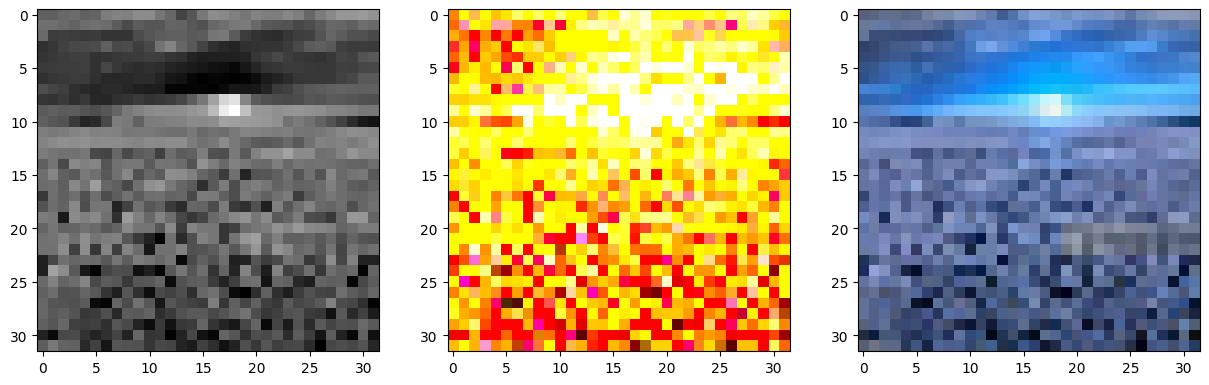

In [9]:
def display_images(batch_size, batch_no, idx_in_batch, directory):

    fig, ax = plt.subplots(1,3,figsize = (15,5))
    images = load_resize_batch(batch_no, batch_size, directory)
    ax[0].imshow(images[idx_in_batch][:,:,0].astype(int),cmap='gray')
    ax[2].imshow(images[idx_in_batch].astype(int))

    x, y = preprocess_batch(images)
    x, y = x.to('cuda'), y.to('cuda')
    predictions = gen.forward(x)
    predictions = torch.cat((x[idx_in_batch],
                             predictions[idx_in_batch]),0).to('cpu').detach().numpy()
    predictions = np.moveaxis(np.rint((predictions * 128)+127),0,2)
    #print(predictions.shape)
    predictions = cv2.cvtColor(predictions, cv2.COLOR_LAB2RGB)
    ax[1].imshow(predictions)

display_images(12,12,9,train_dir)